<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/LabAssignmentCNNAudio_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
import tensorflow.keras as keras

from IPython import display

import librosa
import librosa.display as lbd
try:
    import samplerate
except ModuleNotFoundError:
    !pip install samplerate


In [257]:
tf.__version__

'2.10.0'

In [258]:
import tensorflow_datasets as tfds

https://www.tensorflow.org/io/tutorials/audio

This dataset requires the installation of the following package:

In [259]:
!pip install pydub

# Load data

In [260]:
SEED = 42

In [261]:
data_info = tfds.builder('spoken_digit').info
data_info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
    
    5 speakers
    2,500 recordings (50 of each digit per speaker)
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='/home/tdrumond/tensorflow_datasets/spoken_digit/1.0.9',
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervi

In [262]:
train_dataset, validation_dataset , test_dataset = tfds.load(
    'spoken_digit', 
    shuffle_files=True,
    as_supervised=True,
    read_config = tfds.ReadConfig(shuffle_seed=SEED),
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'])

In [263]:
dataset = {'train': train_dataset, 
           'valid': validation_dataset, 
           'test': test_dataset}

In [264]:
for split, ds in dataset.items():
    print(f"{split} size: {ds.cardinality().numpy()} samples")
    labels = [label for audio, label in ds]
    print("class count : ", np.histogram(labels, 10)[0])

train size: 1500 samples
class count :  [158 158 157 150 148 153 145 155 130 146]
valid size: 500 samples
class count :  [45 38 51 48 54 50 49 49 62 54]
test size: 500 samples
class count :  [47 54 42 52 48 47 56 46 58 50]


## Visualizing the waveforms

The dataset description mentions data was sampled at 8kHz. This sampling rate needs to be taken intdo account if we want to retrieve the time lenght of the audio.

In [265]:
def display_sound(waveform, sampling_rate=8000):
    display.display(display.Audio(waveform, rate=sampling_rate))

waveform shape:(1525,), and dtype: <dtype: 'int64'>


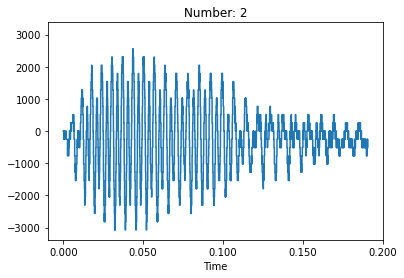

In [266]:
SAMPLING_RATE=8000

waveform, label = next(iter(dataset['train']))
print(f"waveform shape:{waveform.shape}, and dtype: {waveform.dtype}")
# librosa needs waveform to be a numpy float array
librosa.display.waveshow(waveform.numpy().astype(np.float32), sr=SAMPLING_RATE)
plt.title(f'Number: {label}')
plt.show()
display_sound(waveform.numpy())

## Transforming waveform into spectrogram

In [267]:
norm_waveform = waveform.numpy()/waveform.numpy().max()

spec_params = dict(
    n_fft=512,
    win_length=255,
    hop_length=16)

spectrogram = librosa.stft(
    y=norm_waveform,
    **spec_params)

sgam_mag, _ = librosa.magphase(spectrogram)
mel_spec = librosa.feature.melspectrogram(S=sgam_mag, sr=SAMPLING_RATE,)
# Mel-frequency cepstral coefficients (MFCCs)
mfcc_spec = librosa.feature.mfcc(S=mel_spec, sr=SAMPLING_RATE,)


In [268]:
print(f"waveform shape: {waveform.shape}")
print(f"spectrogram shape: {sgam_mag.shape}")

waveform shape: (1525,)
spectrogram shape: (257, 96)


# Preparing the preprocessing pipeline

In [269]:
def apply_dataset_map(dataset, func):
    new_ds = {}
    for key, split_ds in dataset.items():
        new_ds[key] = split_ds.map(func)
    return new_ds

## Decode WAV into normalized float values

In [270]:
def decode_wav(raw_wav, label):
    audio = tf.cast(raw_wav, tf.float32)
    audio /= tf.reduce_max(audio)
    return audio, label


In [271]:
dataset = apply_dataset_map(dataset, decode_wav)

## Trying out data augmentation

In [272]:
try:
    import audiomentations
except ModuleNotFoundError:
    !pip install audiomentations
    import audiomentations

In [273]:
from audiomentations import OneOf, Compose, AddGaussianNoise, PitchShift, TimeStretch

augmentations_pipeline = Compose(
    [
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    ]
)

In [274]:
def apply_augmentation_pipeline(audio, sampling_rate=8000):
    """
    Applies the augmentation pipeline to audio arrays
    Data is manipulated with numpy

    Note: librosa has a defallt n_fft=2048, but some samples are smaller than 
    this (around 1000 time steps). 
    Since audiomentations does note adjust this parameter,
    nor allows us to change it, a reasonable workaround is to upsample
    so waveforms have at least 2048 time steps. 
    Doubling the sampling rate showed to be enough for this dataset.
    """
    audio = librosa.resample(
        audio, 
        orig_sr=sampling_rate, 
        target_sr=2*sampling_rate, 
        res_type='linear')
    changed_audio = augmentations_pipeline(audio, sampling_rate)

    # Downsampling back to original Sampling rate
    changed_audio = librosa.resample(
        changed_audio, 
        orig_sr=2*sampling_rate, 
        target_sr=sampling_rate, 
        res_type='linear')

    return changed_audio


@tf.function
def tf_apply_augmentation_pipeline(audio, label):
    """Tensorflow wrapper function to encapsulate numpy array manipulation"""

    changed_audio = tf.numpy_function(
        apply_augmentation_pipeline, 
        inp=[audio, SAMPLING_RATE], 
        Tout=tf.float32, 
        name="apply_augmentation_pipeline"
    )

    return changed_audio, label


In [275]:
augmented_dataset = apply_dataset_map(dataset, tf_apply_augmentation_pipeline)

In [276]:
for audio, label in augmented_dataset['train'].take(5):
    print(f"Waveform length: {len(audio)}")
    print(f"digit: {label}")
    display_sound(audio)

Waveform length: 1525
digit: 2


Waveform length: 2929
digit: 1


Waveform length: 6457
digit: 9


Waveform length: 3360
digit: 9


Waveform length: 2746
digit: 7


In [277]:
for audio, label in dataset['train'].take(5):
    print(f"Waveform length: {len(audio)}")
    print(f"digit: {label}")
    display_sound(audio)

Waveform length: 1525
digit: 2


Waveform length: 2929
digit: 1


Waveform length: 6457
digit: 9


Waveform length: 3360
digit: 9


Waveform length: 2746
digit: 7


## Pad/trim

(1148, 3188.0, 18262)

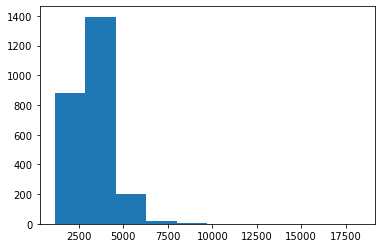

In [278]:
length = [sample.shape[0] for sample, lable in dataset['train']]
length += [sample.shape[0] for sample, lable in dataset['valid']]
length += [sample.shape[0] for sample, lable in dataset['test']]
length = np.array(length)
plt.hist(length)
length.min(), np.median(length), length.max()

The majority of audio samples last under 7500 samples, which is less than 1s at 8000Hz sampling rate. We'll set an upper limit of 8000 samples ( = 1s).

In [279]:
MAX_TIMESAMPLES = 8000

In [280]:
def pad_or_trim(audio, label):   
    # pad and trim
    audio = tf.concat([audio, tf.zeros(MAX_TIMESAMPLES)], axis=0)
    audio = audio[:MAX_TIMESAMPLES]
    return audio, label

In [281]:
dataset = apply_dataset_map(dataset, pad_or_trim)
augmented_dataset = apply_dataset_map(augmented_dataset, pad_or_trim)

## Transform into spectrogram

In [282]:


def get_spectrogram(audio, sampling_rate=8000):
    """
    Applies the augmentation pipeline to audio arrays
    Data is manipulated with numpy

    """

    # generate spectrogram
    spec_params = dict(
    n_fft=512,
    win_length=255,
    hop_length=16)
    # Basic spectrogram
    spectrogram = librosa.stft(
        y=audio,
        **spec_params)
    # Extract only magnitude of the spectrum
    sgam_mag, _ = librosa.magphase(spectrogram)
    # Convet to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=sgam_mag, sr=SAMPLING_RATE,)
    # Convert to Mel-frequency cepstral coefficients (MFCCs)
    # More adapted to speech processing
    mfcc_spec = librosa.feature.mfcc(S=mel_spec, sr=SAMPLING_RATE,)
    # Transpose so we have shape [time, freq]
    return mfcc_spec.T


@tf.function
def tf_get_spectrogram(audio, label):
    """Tensorflow wrapper function to encapsulate numpy array manipulation"""

    spectrogram = tf.numpy_function(
        get_spectrogram, 
        inp=[audio, SAMPLING_RATE], 
        Tout=tf.float32, 
        name="get_spectrogram"
    )

    return spectrogram, label


In [283]:
dataset = apply_dataset_map(dataset, tf_get_spectrogram)
augmented_dataset = apply_dataset_map(augmented_dataset, tf_get_spectrogram)

In [284]:
input_shape = next(iter(dataset['train']))[0].shape
input_shape

TensorShape([501, 20])

In [285]:
next(iter(augmented_dataset['valid']))[0].shape

TensorShape([501, 20])

## Batching

In [286]:
batch_size = 32

In [287]:
tf.keras.utils.set_random_seed(SEED)

AUTOTUNE = tf.data.AUTOTUNE

n_train_samples = dataset['train'].cardinality()

dataset['train'] = dataset['train'].cache().shuffle(n_train_samples).batch(batch_size).prefetch(AUTOTUNE)
augmented_dataset['train'] = augmented_dataset['train'].cache().shuffle(n_train_samples).batch(batch_size).prefetch(AUTOTUNE)
for split in ['valid', 'test']:
    dataset[split] = dataset[split].batch(batch_size)
    augmented_dataset[split] = augmented_dataset[split].batch(batch_size)

# Tensorboard session

In [85]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Training some models

In [219]:
EPOCHS = 15

## Baseline - linear model

In [343]:
MODEL_NAME = 'linear_model'

In [344]:
tf.keras.utils.set_random_seed(SEED)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(10)
])
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 10020)             0         
                                                                 
 dense_7 (Dense)             (None, 10)                100210    
                                                                 
Total params: 100,210
Trainable params: 100,210
Non-trainable params: 0
_________________________________________________________________


In [345]:
sparse_categorical_crossentropy_from_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='rmsprop',
            loss=sparse_categorical_crossentropy_from_logits,
            metrics='accuracy')


In [355]:
def best_model_path(model_name):
    base_dir  = os.path.join('logs', model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name, reset=True):
    base_dir  = os.path.join('logs', model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir, 
        delete_checkpoint=False
        )
    if reset:
        shutil.rmtree(backup_dir, ignore_errors=True)
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=False,
        verbose=1
    )
    return [tb_cb, es, ckpt, bkp]


In [347]:
model.fit(
    dataset['train'],
    epochs=EPOCHS,
    callbacks=callback_list(MODEL_NAME),
    validation_data=dataset['valid'])

Epoch 1/15
47/47 [==============================] - ETA: 0s - loss: 1.0708 - accuracy: 0.6613INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 22s 467ms/step - loss: 1.0708 - accuracy: 0.6613 - val_loss: 0.7596 - val_accuracy: 0.7680
Epoch 2/15
44/47 [===========================>..] - ETA: 0s - loss: 0.5896 - accuracy: 0.8274INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 13s 290ms/step - loss: 0.5984 - accuracy: 0.8247 - val_loss: 0.6178 - val_accuracy: 0.8260
Epoch 3/15
43/47 [==========================>...] - ETA: 0s - loss: 0.4475 - accuracy: 0.8757INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 21s 460ms/step - loss: 0.4465 - accuracy: 0.8767 - val_loss: 0.5571 - val_accuracy: 0.8280
Epoch 4/15
41/47 [=========================>....] - ETA: 0s - loss: 0.3634 - accuracy: 0.8979INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 21s 461ms/step - loss: 0.3663 - accuracy: 0.8947 - val_loss: 0.4757 - val_accuracy: 0.8620
Epoch 5/15
40/47 [========================>.....] - ETA: 0s - loss: 0.2987 - accuracy: 0.9312INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 11s 239ms/step - loss: 0.2933 - accuracy: 0.9307 - val_loss: 0.4470 - val_accuracy: 0.8740
Epoch 6/15
44/47 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.9261INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 13s 290ms/step - loss: 0.2608 - accuracy: 0.9287 - val_loss: 0.4374 - val_accuracy: 0.8760
Epoch 7/15
42/47 [=========================>....] - ETA: 0s - loss: 0.2265 - accuracy: 0.9487INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 21s 460ms/step - loss: 0.2251 - accuracy: 0.9473 - val_loss: 0.4231 - val_accuracy: 0.8880
Epoch 8/15
47/47 [==============================] - 9s 194ms/step - loss: 0.1965 - accuracy: 0.9547 - val_loss: 0.4294 - val_accuracy: 0.8720
Epoch 9/15
47/47 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9587INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/linear_model/best_val_accuracy.ckpt/assets


47/47 [==============================] - 11s 238ms/step - loss: 0.1741 - accuracy: 0.9587 - val_loss: 0.4051 - val_accuracy: 0.8940
Epoch 10/15
47/47 [==============================] - 11s 231ms/step - loss: 0.1480 - accuracy: 0.9707 - val_loss: 0.4236 - val_accuracy: 0.8860
Epoch 11/15
47/47 [==============================] - 11s 231ms/step - loss: 0.1457 - accuracy: 0.9640 - val_loss: 0.4250 - val_accuracy: 0.8800
Epoch 12/15
47/47 [==============================] - 11s 231ms/step - loss: 0.1288 - accuracy: 0.9720 - val_loss: 0.4318 - val_accuracy: 0.8820
Epoch 13/15
47/47 [==============================] - 10s 208ms/step - loss: 0.1116 - accuracy: 0.9800 - val_loss: 0.4559 - val_accuracy: 0.8860
Epoch 14/15
47/47 [==============================] - 11s 230ms/step - loss: 0.1054 - accuracy: 0.9713 - val_loss: 0.4276 - val_accuracy: 0.8940
Epoch 15/15
47/47 [==============================] - 9s 203ms/step - loss: 0.0926 - accuracy: 0.9807 - val_loss: 0.4192 - val_accuracy: 0.8900


In [227]:
model = tf.keras.models.load_model(best_model_path(MODEL_NAME))
model.evaluate(augmented_dataset['test'])

16/16 [==============================] - 22s 1s/step - loss: 1.3526 - accuracy: 0.6940


[1.3526337146759033, 0.6940000057220459]

In [247]:
def train_and_eval(model, augment=False, optimizer=None, reset=False):
    sparse_categorical_crossentropy_from_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer or 'rmsprop',
            loss=sparse_categorical_crossentropy_from_logits,
            metrics='accuracy')
    # Reset model initial weights so we get comparable results
    if reset:
        model.load_weights('model_init.h5')
    # train
    logs = model.fit(
        augmented_dataset['train'] if augment else dataset['train'],
        epochs=EPOCHS,
        callbacks=callback_list(MODEL_NAME, reset=reset),
        validation_data=dataset['valid'],
        verbose=0)
    # laod best model (according to validation accuracy)
    # and evaluate on test set
    model = tf.keras.models.load_model(best_model_path(MODEL_NAME))
    print('Test loss and accuracy:')
    model.evaluate(dataset['test'])
    return logs

## Base CNN model

In [288]:
MODEL_NAME = 'base_model'

In [289]:
input_shape

TensorShape([501, 20])

In [350]:
tf.keras.utils.set_random_seed(SEED)

model = keras.models.Sequential(name=MODEL_NAME)

# shape is time steps x freq
model.add(keras.layers.InputLayer(input_shape=input_shape))
rates = (1, 2, 4, 8)

for rate in rates:
    model.add(
        keras.layers.Conv1D(
            filters=input_shape[1], kernel_size=2, activation="relu", 
            padding="causal", dilation_rate=rate, name=f'dilation_{rate}'))

model.add(keras.layers.Lambda(
    lambda x: tf.expand_dims(x, axis=-1), name='expand_dims'))
model.add(keras.layers.Conv2D(32, 3, strides=(2,1), activation="relu", padding="same", name='conv2D_1'))
model.add(keras.layers.Conv2D(32, 3, strides=(2,1), activation="relu", padding="same", name='conv2D_2'))
model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation="relu", padding="same", name='conv2D_3'))
model.add(keras.layers.Flatten(name='flatten'))
model.add(tf.keras.layers.Dense(32, name="fc_4"))
model.add(tf.keras.layers.Dense(10, name="output"))
model.summary()
model.save_weights('model_init.h5')

Model: "augment"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dilation_1 (Conv1D)         (None, 501, 20)           820       
                                                                 
 dilation_2 (Conv1D)         (None, 501, 20)           820       
                                                                 
 dilation_4 (Conv1D)         (None, 501, 20)           820       
                                                                 
 dilation_8 (Conv1D)         (None, 501, 20)           820       
                                                                 
 expand_dims (Lambda)        (None, 501, 20, 1)        0         
                                                                 
 conv2D_1 (Conv2D)           (None, 251, 20, 32)       320       
                                                                 
 conv2D_2 (Conv2D)           (None, 126, 20, 32)       9248

In [342]:
train_and_eval(model, augment=False, reset=True)

INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/base_model/best_val_accuracy.ckpt/assets


Test loss and accuracy:
16/16 [==============================] - 9s 533ms/step - loss: 0.4038 - accuracy: 0.9160


## Base CNN model + augmented data

In [356]:
MODEL_NAME = 'augment'

In [357]:
# model.optimizer.learning_rate = 5e-4
train_and_eval(
    model, 
    augment=True, 
    reset=True)

2022-10-31 15:32:02.576865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1500
2022-10-31 15:32:12.605360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 458 of 1500
2022-10-31 15:32:22.561022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 683 of 1500
2022-10-31 15:32:32.579340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 922 of 1500
2022-10-31 15:32:42.639231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1141 of 1500
2022-10-31 15:32:52.577635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1364 of 1500
2022-10-31 15:32:57.992170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer fil

INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/augment/best_val_accuracy.ckpt/assets


Test loss and accuracy:
16/16 [==============================] - 10s 578ms/step - loss: 0.5368 - accuracy: 0.8980


# Tuning HP with KerasTuner



In [106]:
try:
    import keras_tuner
except ModuleNotFoundError:
    !pip install keras-tuner --upgrade
    import keras_tuner


https://keras.io/api/keras_tuner/hyperparameters/#float-method

## Build model

In [117]:
def build_model(hp):
    l2_weigth = hp.Float(
        'L2',
        1e-9, 1e-3,
        sampling='log')
    dropout_rate = hp.Float(
        'dropout',
        0., 0.6,
        sampling='linear',
        default=0.)
    lr = hp.Float(
        'learning_rate',
        1e-6, 1e-3,
        sampling='log',
        default=0.001)
    units = hp.Choice(
        'units', 
        [32,64,128],
        default=128)

    tf.keras.utils.set_random_seed(SEED)

    l2_reg = tf.keras.regularizers.L2(l2_weigth)

    model.add(keras.layers.InputLayer(input_shape=input_shape))
    rates = (1, 2, 4, 8)

    for rate in rates:
        model.add(
            keras.layers.Conv1D(
                filters=input_shape[1], kernel_size=2, activation="relu", 
                padding="causal", dilation_rate=rate, name=f'dilation_{rate}'))

    model.add(keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1), name='expand_dims'))
    model.add(keras.layers.Conv2D(32, 3, strides=(2,1), activation="relu", padding="same", kernel_regularizer=l2_reg, name='conv2D_1'))
    model.add(keras.layers.Conv2D(32, 3, strides=(2,1), activation="relu", padding="same", kernel_regularizer=l2_reg, name='conv2D_2'))
    model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation="relu", padding="same", kernel_regularizer=l2_reg, name='conv2D_3'))
    model.add(keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(32, 
        kernel_regularizer=l2_reg, name="fc_4"))
    model.add(tf.keras.layers.Dense(10, 
        kernel_regularizer=l2_reg,name="output"))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
                  metrics=['accuracy'])
    
    return model


## Search

In [118]:
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

tuner = keras_tuner.BayesianOptimization(
    build_model,
    max_trials=10,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="val_accuracy",
    # Set a directory to store the intermediate results.
    directory="/tmp/tb",
    seed=SEED)

tuner.search(augmented_dataset['train'],
             epochs=EPOCHS,
             callbacks=callback_list("hp_tuning")[:2],
             validation_data=dataset['valid'],
             verbose=0)


2022-10-26 17:48:56.285086: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x563835b173b0


Epoch 38: early stopping


Epoch 36: early stopping


Epoch 29: early stopping


Epoch 39: early stopping
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


## Evaluate best hp set

In [132]:
tuner.get_best_hyperparameters()[0].values

{'L2': 0.01, 'dropout': 0.0, 'learning_rate': 0.001, 'units': 128}

In [119]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(augmented_dataset['test'])

16/16 [==============================] - 9s 551ms/step - loss: 0.7529 - accuracy: 0.8720


[0.7528842687606812, 0.871999979019165]

HP tuning could not find something better than the base model without dropout nor L2 reg.

# Test model on your own audio

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
source: https://kubilaybozak.medium.com/record-audio-from-your-microphone-in-colab-colab-%C3%BCzerinden-mikrofon-ile-ses-kayd%C4%B1-alma-bfa56013624e
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display.display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# audio,sr = get_audio()

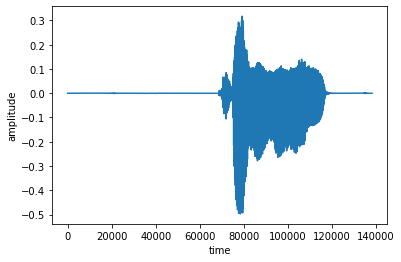

In [ ]:
test_sample = audio/(2**16)
plot_waveform(test_sample)
display_sound(test_sample, sr)

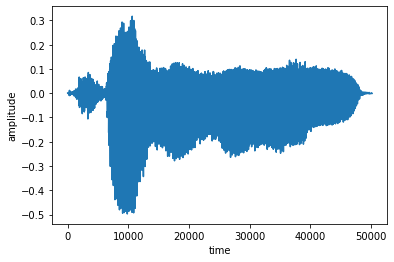

In [ ]:
test_sample,_ = librosa.effects.trim(test_sample, top_db=40)
plot_waveform(test_sample)
display_sound(test_sample, sr)

In [ ]:
test_sample = librosa.resample(test_sample, sr, SAMPLING_RATE)
test_sample = np.concatenate([test_sample, np.zeros(8000)])[:8000]

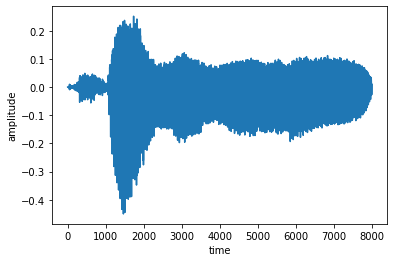

In [ ]:
plot_waveform(test_sample)
display_sound(test_sample)

In [ ]:
spec = get_spectrogram(test_sample)

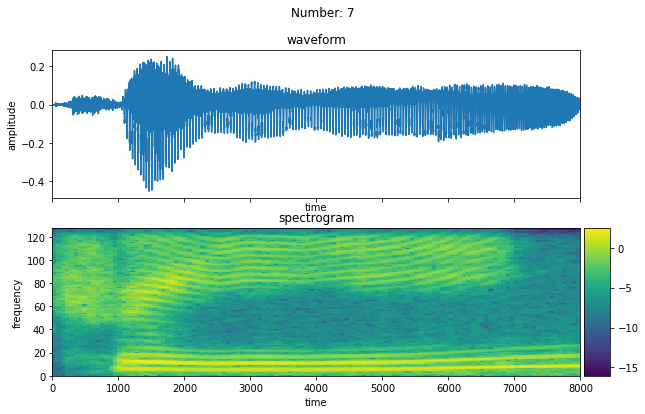

In [ ]:
plot_wave_spectre(tf.constant(test_sample), spec)

In [ ]:
logits = model.predict(tf.expand_dims(tf.expand_dims(spec, axis=-1), axis=0))

1/1 [==============================] - 0s 49ms/step


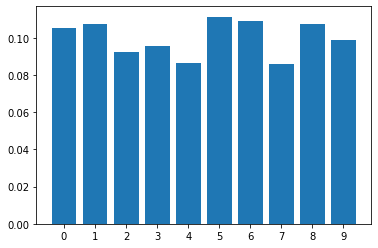

In [ ]:
plt.bar(np.arange(10), tf.nn.softmax(logits).numpy().squeeze())
plt.xticks(np.arange(10))
plt.show()